In [ ]:
%matplotlib inline
from copy import deepcopy
from collections import OrderedDict
import gc
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD,Adam,lr_scheduler
from torch.utils.data import random_split
import torchvision
from torchvision import transforms,models

In [ ]:
!tar -zxvf ../input/cifar10-python/cifar-10-python.tar.gz


tar (child): ../input/cifar10-python/cifar-10-python.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(p=.40),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

traindata = torchvision.datasets.CIFAR10(root='.', train=True,download=True , transform=train_transform)
trainset,valset = random_split(traindata,[42000,8000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64,shuffle=False)

testset = torchvision.datasets.CIFAR10(root='.', train=False,download=False, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=False)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet18(pretrained=True)
        self.base = nn.Sequential(*list(base.children())[:-1])
        in_features = base.fc.in_features
        self.drop = nn.Dropout()
        self.final = nn.Linear(in_features,10)
    
    def forward(self,x):
        x = self.base(x)
        x = self.drop(x.view(-1,self.final.in_features))
        return self.final(x)
    
model = Model().cuda()
[x for x,y in model.named_children()]

['base', 'drop', 'final']

In [ ]:
criterion = nn.CrossEntropyLoss()
param_groups = [
    {'params':model.base.parameters(),'lr':.0001},
    {'params':model.final.parameters(),'lr':.001}
]
optimizer = Adam(param_groups)
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
states = {}

In [ ]:
%%time
best_val_acc = -1000
best_val_model = None
for epoch in range(5):  
    model.train(True)
    running_loss = 0.0
    running_acc = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.cuda(),labels.cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item() * inputs.size(0)
        out = torch.argmax(outputs.detach(),dim=1)
        assert out.shape==labels.shape
        running_acc += (labels==out).sum().item()
    print(f"Train loss {epoch+1}: {running_loss/len(trainset)},Train Acc:{running_acc*100/len(trainset)}%")
    
    correct = 0
    model.train(False)
    with torch.no_grad():
        for inputs,labels in valloader:
            out = model(inputs.cuda()).cpu()
            out = torch.argmax(out,dim=1)
            acc = (out==labels).sum().item()
            correct += acc
    print(f"Val accuracy:{correct*100/len(valset)}%")
    if correct>best_val_acc:
        best_val_acc = correct
        best_val_model = deepcopy(model.state_dict())
    lr_scheduler.step()
    
print('Finished Training')  

Train loss 1: 0.5036816781702496,Train Acc:82.62619047619047%
Val accuracy:90.0375%
Train loss 2: 0.21972936637628646,Train Acc:92.3952380952381%
Val accuracy:92.5875%
Train loss 3: 0.19656409499191102,Train Acc:93.27380952380952%
Val accuracy:93.2875%
Train loss 4: 0.1907830688499269,Train Acc:93.69047619047619%
Val accuracy:92.825%
Train loss 5: 0.19326239781152635,Train Acc:93.45476190476191%
Val accuracy:93.1625%
Finished Training
CPU times: user 17min 46s, sys: 19.6 s, total: 18min 5s
Wall time: 18min 6s


In [ ]:
%%time
correct = 0
model.load_state_dict(best_val_model)
model.train(False)
with torch.no_grad():
    for inputs,labels in testloader:
        out = model(inputs.cuda()).cpu()
        out = torch.argmax(out,dim=1)
        acc = (out==labels).sum().item()
        
        correct += acc
print(f"Test accuracy: {correct*100/len(testset)}%")

Test accuracy: 94.02%
CPU times: user 22.1 s, sys: 627 ms, total: 22.7 s
Wall time: 22.8 s


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
train_losses = [0.5036816781702496, 0.21972936637628646,0.19656409499191102,0.1907830688499269,0.19326239781152635]
val_acc = [90.0375,92.5875,93.2875,92.825,93.1625]
epochs = [1,2,3,4,5]

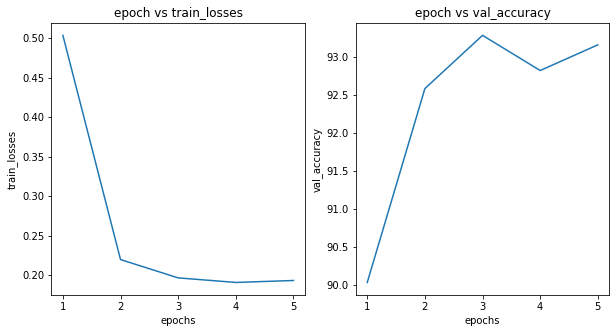

In [6]:
#plot 1:
plt.rcParams["figure.figsize"] = (10,5)
plt.subplot(1, 2, 1)
plt.xlabel('epochs')
plt.ylabel('train_losses')
plt.plot(epochs,train_losses)
plt.title('epoch vs train_losses')
#plot 2:
plt.subplot(1, 2, 2)
plt.xlabel('epochs')
plt.ylabel('val_accuracy')
plt.plot(epochs,val_acc)
plt.title('epoch vs val_accuracy')

plt.show()